In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import glob
import os
import sys
import torch

In [2]:

RESULT_ROOT_FOLDER = "/scratch/staff/ak1774/INDIRECT_MAML_ARCHIVE/unzipped/maml_runs/"
EXPERIMENT_FOLDERS_TO_LOAD = [
    "FAIR_SMALL_NET_REPEAT_11_11___17:02",
]

In [3]:
def load_results(experiment_folder):
    

    CONFIG_FOLDERS = [os.path.join(experiment_folder, config_folder) 
               for config_folder in os.listdir(experiment_folder) if "config_" in config_folder]

    CONFIG_FILES = [os.path.join(config_folder,"config.json") for config_folder in CONFIG_FOLDERS]
    
    results = []

    things_to_load = [
        "gen_adapted_test_losses",
        "gen_adapted_test_accuracies",
        "eval_adapted_test_losses",
        "eval_adapted_test_accuracies",
        "adaptation_curve_accuracies",
    ]

    for config_file,run_folder in zip(CONFIG_FILES,CONFIG_FOLDERS):

        run_data = {}

        with open(config_file) as f:
            config = json.load(f)

        run_data["folder"] = os.path.basename(os.path.normpath(experiment_folder))
        run_data["config"] = config
        run_data["config_fn"] = config_file

        everything_ok = True
        
        for thing in things_to_load:
            fname = os.path.join(run_folder,thing + ".npy")
            if os.path.isfile(fname):
                #print(fname)
                try:
                    run_data[thing] = np.load(fname)
                except ValueError:
                    print("failed to load ",fname)
                    everything_ok = False
                    break
        
        if everything_ok is False:
            break
                    
        
        fname=os.path.join(run_folder,'theta.torch')
        run_data["params_fname"] = fname
        if os.path.isfile(fname):
            run_data["num_params"] = torch.load(fname).numel()
        else:
            run_data["num_params"] = None
        
        results.append(run_data)
        

        
    return results,CONFIG_FOLDERS

In [4]:
experiment_folders = [RESULT_ROOT_FOLDER+f  for f in EXPERIMENT_FOLDERS_TO_LOAD]
results = []
for folder in experiment_folders:
    print(folder)
    res,CONFIG_FOLDERS = load_results(folder)
    print(len(res),folder)
    results.extend(res)
len(results)

/scratch/staff/ak1774/INDIRECT_MAML_ARCHIVE/unzipped/maml_runs/FAIR_SMALL_NET_REPEAT_11_11___17:02
63 /scratch/staff/ak1774/INDIRECT_MAML_ARCHIVE/unzipped/maml_runs/FAIR_SMALL_NET_REPEAT_11_11___17:02


63

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

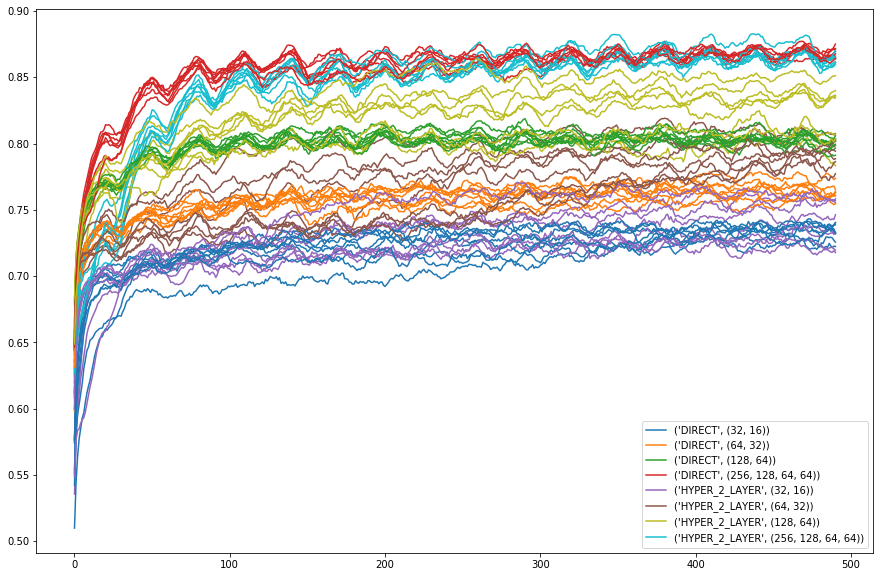

In [17]:

KEYS = [
    ('DIRECT', (32, 16)),
    ('DIRECT', (64, 32)),
    ('DIRECT', (128, 64)),
    ('DIRECT', (256, 128, 64, 64)),
    ('HYPER_2_LAYER', (32, 16)),
    ('HYPER_2_LAYER', (64, 32)),
    ('HYPER_2_LAYER', (128, 64)),
    ('HYPER_2_LAYER', (256, 128, 64, 64)),
]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:olive","tab:cyan",]
colors = {key : colors[i] for i,key in enumerate(KEYS)}

# plot empty lines to create legend
for key,color in colors.items():
    plt.plot([], color=color, label=str(key))
plt.legend()

eval_accuracy_after_3_grad_steps = { key : [] for key in KEYS}

for res in results[::]:
    configuration = (res["config"]["POLICY_TYPE"],
                         tuple(res["config"]["FULLY_CONNECTED_HIDDEN_DIMS_OMNIGLOT"]))
    if configuration not in KEYS:
        continue
    
    eval_accuracy_after_3_grad_steps[configuration].append(res["adaptation_curve_accuracies"][-1])
    
    learning_curve = res["gen_adapted_test_accuracies"]
    learning_curve = np.convolve(learning_curve,np.ones(100)/100,mode="valid")
    #plt.plot(learning_curve[::100],color=colors[configuration])
    
    bbb = res["eval_adapted_test_accuracies"]
    bbb = np.convolve(bbb,np.ones(10)/10,mode="valid")
    plt.plot(bbb,color=colors[configuration])

Text(0.5, 69.0, 'Network size')

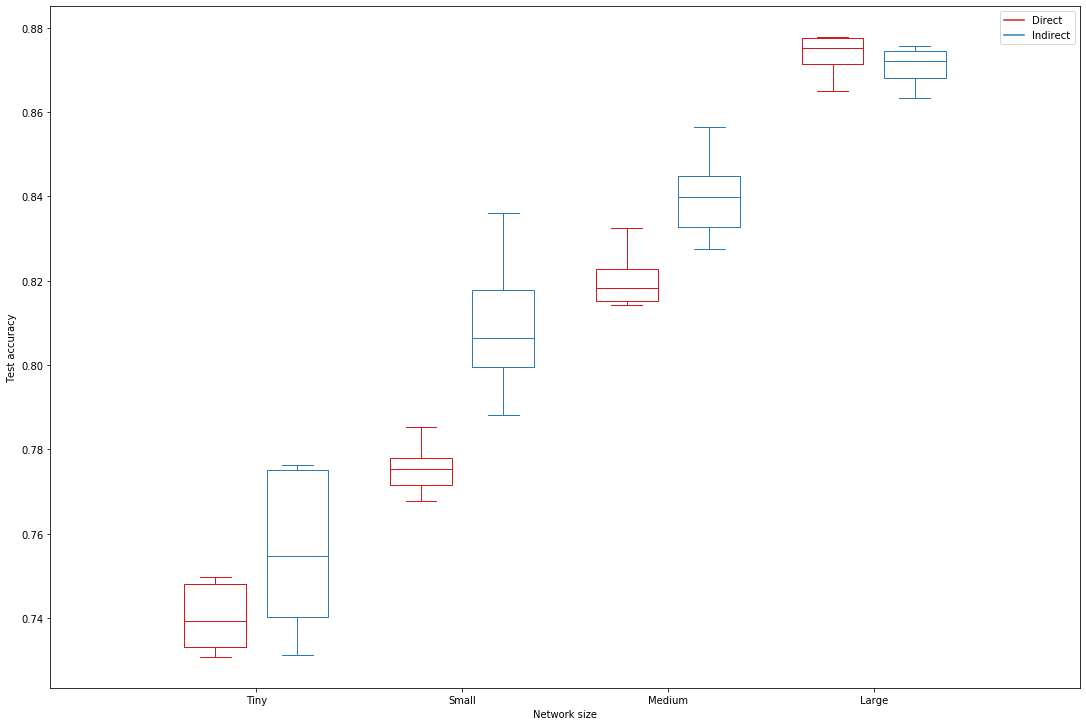

In [18]:

# https://stackoverflow.com/questions/16592222/matplotlib-group-boxplots

direct_keys = KEYS[0:4]
indirect_keys = KEYS[4:8]

data_direct = [eval_accuracy_after_3_grad_steps[key] for key in direct_keys]
data_indirect = [eval_accuracy_after_3_grad_steps[key] for key in indirect_keys]

ticks = ['Tiny', 'Small', 'Medium', "Large"]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(data_direct, positions=np.array(range(len(data_direct)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_indirect, positions=np.array(range(len(data_indirect)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Direct')
plt.plot([], c='#2C7BB6', label='Indirect')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
#plt.ylim(0, 8)
plt.tight_layout()
plt.ylabel("Test accuracy")
plt.xlabel("Network size")
    